In [39]:
import pandas as pd

df = pd.read_csv("../data/raw/legal_text_classification.csv")
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


Aqui analizamos la estructura del dataset para entender que tenemos. Con info() revisamos si hay valores nulos y los tipos de datos. Con value_counts() observamos cuantos documentos hay por cada categoria. Esto es importante porque si una clase tiene muchos mas datos que otra, el modelo puede sesgarse. Esta etapa nos permite detectar problemas antes de comenzar el analisis profundo.

In [40]:
df.info()
df.describe()
df['case_outcome'].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   case_id       24985 non-null  str  
 1   case_outcome  24985 non-null  str  
 2   case_title    24985 non-null  str  
 3   case_text     24809 non-null  str  
dtypes: str(4)
memory usage: 780.9 KB


case_outcome
cited            12219
referred to       4384
applied           2448
followed          2256
considered        1712
discussed         1024
distinguished      608
related            113
affirmed           113
approved           108
Name: count, dtype: int64

En este bloque limpiamos los textos legales con un pipeline mejorado. Convertimos a minusculas, eliminamos numeros y puntuacion, quitamos stopwords y aplicamos **lematizacion** con WordNetLemmatizer: reduce palabras a su forma base ("exercised" -> "exercise", "courts" -> "court"), lo que reduce el vocabulario y mejora la generalizacion del modelo. Tambien eliminamos tokens de menos de 3 caracteres y las filas con texto vacio.

In [41]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df = df.dropna(subset=["case_text"]).reset_index(drop=True)
df["clean_text"] = df["case_text"].astype(str).apply(clean_text)
df[["case_text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\isave\AppData\Roaming\nltk_data...


,case_text,clean_text
0,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
1,The general principles governing the exercise ...,general principle governing exercise discretio...
2,Ordinarily that discretion will be exercised s...,ordinarily discretion exercised cost follow ev...
3,The general principles governing the exercise ...,general principle governing exercise discretio...
4,The preceding general principles inform the ex...,preceding general principle inform exercise di...


Aqui unimos todos los textos limpios y contamos cuantas veces aparece cada palabra. Esto permite identificar los terminos mas comunes en el lenguaje juridico del dataset. El grafico de barras muestra que palabras dominan el corpus y ayuda a detectar patrones tematicos.

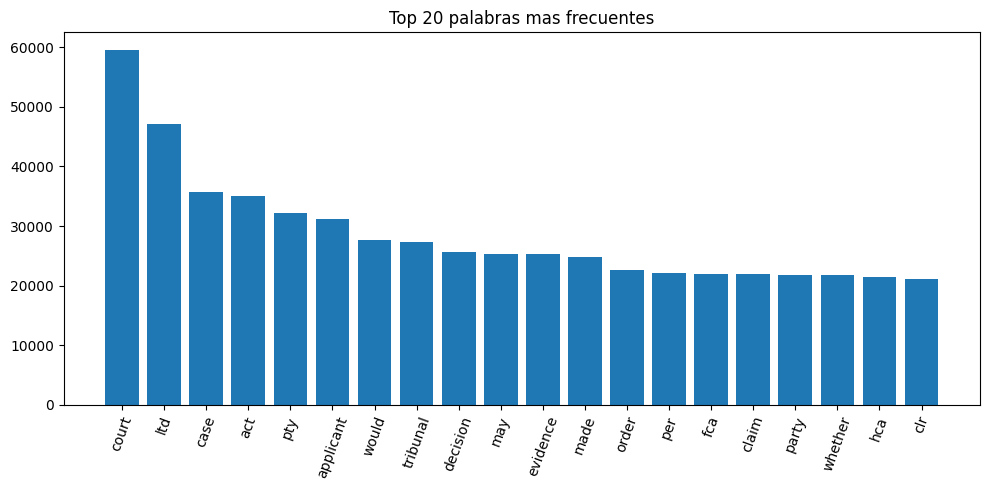

In [42]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = " ".join(df["clean_text"]).split()
freq = Counter(all_words)
common = freq.most_common(20)
words, counts = zip(*common)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=70)
plt.title("Top 20 palabras mas frecuentes")
plt.tight_layout()
plt.show()

Convertimos el texto en vectores numericos usando **TF-IDF mejorado**. Ademas de palabras individuales (unigramas), incluimos **bigramas** (pares de palabras consecutivas), lo que captura frases como "referred to" o "applied for". Con min_df=3 eliminamos terminos rarisimos (ruido) y con max_df=0.85 descartamos los demasiado comunes. sublinear_tf=True aplica logaritmo al TF para suavizar pesos extremos.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["case_outcome"]

print(f"Dimensiones de la matriz TF-IDF: {X.shape}")
print(f"Distribucion de clases:\n{y.value_counts()}")

Dimensiones de la matriz TF-IDF: (24809, 10000)
Distribucion de clases:
case_outcome
cited            12110
referred to       4363
applied           2438
followed          2252
considered        1699
discussed         1018
distinguished      603
related            112
approved           108
affirmed           106
Name: count, dtype: int64


Dividimos el dataset con stratify=y para garantizar que cada particion tenga la misma proporcion de clases que el dataset original, lo cual es critico con datos desbalanceados. Luego entrenamos una Regresion Logistica con class_weight="balanced", que ajusta automaticamente los pesos de cada clase inversamente proporcional a su frecuencia, dandole mas importancia a las clases minoritarias durante el entrenamiento.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_lr = LogisticRegression(max_iter=1000, class_weight="balanced", C=1.0)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("=== Regresion Logistica (mejorada) ===")
print(classification_report(y_test, y_pred_lr, zero_division=0))

=== Regresion Logistica (mejorada) ===
               precision    recall  f1-score   support

     affirmed       0.30      0.76      0.43        21
      applied       0.26      0.37      0.30       488
     approved       0.09      0.24      0.13        21
        cited       0.77      0.43      0.55      2422
   considered       0.24      0.38      0.30       340
    discussed       0.20      0.46      0.28       204
distinguished       0.21      0.48      0.29       121
     followed       0.28      0.34      0.30       450
  referred to       0.44      0.45      0.45       873
      related       0.15      0.55      0.23        22

     accuracy                           0.42      4962
    macro avg       0.29      0.45      0.33      4962
 weighted avg       0.54      0.42      0.45      4962



## Comparacion de Modelos

Evaluamos cuatro algoritmos distintos para identificar cual ofrece mejor rendimiento. Usamos macro F1-score como metrica principal porque trata todas las clases por igual, penalizando el mal desempeno en clases minoritarias, algo critico dado el desbalance del dataset. Los modelos evaluados son: Regresion Logistica (ya entrenada), Naive Bayes Multinomial, LinearSVC (SVM lineal) y Random Forest.

In [45]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

modelos = {
    "Logistic Regression": model_lr,
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "LinearSVC": LinearSVC(class_weight="balanced", max_iter=2000, C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1)
}

resultados = {}
for nombre, modelo in modelos.items():
    if nombre != "Logistic Regression":
        modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = np.mean(y_pred == y_test)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    resultados[nombre] = {"Accuracy": acc, "F1 Macro": f1_macro, "F1 Weighted": f1_weighted}
    print(f"\n" + "="*40)
    print(f"  {nombre}")
    print(f"  Accuracy:    {acc:.4f}")
    print(f"  F1 Macro:    {f1_macro:.4f}")
    print(f"  F1 Weighted: {f1_weighted:.4f}")

df_resultados = pd.DataFrame(resultados).T.sort_values("F1 Macro", ascending=False)
print("\n=== Ranking de modelos por F1 Macro ===")
print(df_resultados.round(4))


  Logistic Regression
  Accuracy:    0.4206
  F1 Macro:    0.3265
  F1 Weighted: 0.4490

  Naive Bayes
  Accuracy:    0.5177
  F1 Macro:    0.2356
  F1 Weighted: 0.4246

  LinearSVC
  Accuracy:    0.5351
  F1 Macro:    0.3965
  F1 Weighted: 0.5457

  Random Forest
  Accuracy:    0.5713
  F1 Macro:    0.3333
  F1 Weighted: 0.5111

=== Ranking de modelos por F1 Macro ===
                     Accuracy  F1 Macro  F1 Weighted
LinearSVC              0.5351    0.3965       0.5457
Random Forest          0.5713    0.3333       0.5111
Logistic Regression    0.4206    0.3265       0.4490
Naive Bayes            0.5177    0.2356       0.4246


## Optimizacion de Hiperparametros con GridSearchCV

Ajustamos los hiperparametros del mejor modelo mediante busqueda en grilla con validacion cruzada de 5 pliegues. GridSearchCV prueba sistematicamente todas las combinaciones de parametros y selecciona la que maximiza el F1 macro promedio en validacion.

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid_svc = {"C": [0.01, 0.1, 1.0, 10.0]}
svc_base = LinearSVC(class_weight="balanced", max_iter=3000)

grid_search = GridSearchCV(
    svc_base, param_grid_svc,
    cv=5, scoring="f1_macro", n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Mejor parametro: {grid_search.best_params_}")
print(f"Mejor F1 Macro en CV: {grid_search.best_score_:.4f}")

mejor_modelo = grid_search.best_estimator_
y_pred_best = mejor_modelo.predict(X_test)

print("\n=== Mejor Modelo (LinearSVC optimizado) ===")
print(classification_report(y_test, y_pred_best, zero_division=0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parametro: {'C': 1.0}
Mejor F1 Macro en CV: 0.3993

=== Mejor Modelo (LinearSVC optimizado) ===
               precision    recall  f1-score   support

     affirmed       0.37      0.52      0.43        21
      applied       0.33      0.35      0.34       488
     approved       0.20      0.38      0.26        21
        cited       0.74      0.65      0.69      2422
   considered       0.33      0.40      0.36       340
    discussed       0.27      0.42      0.33       204
distinguished       0.31      0.38      0.34       121
     followed       0.34      0.36      0.35       450
  referred to       0.52      0.51      0.52       873
      related       0.37      0.32      0.34        22

     accuracy                           0.54      4962
    macro avg       0.38      0.43      0.40      4962
 weighted avg       0.56      0.54      0.55      4962



## Visualizaciones de Evaluacion

La **matriz de confusion** muestra cuantos documentos de cada clase real fueron clasificados en cada clase predicha. La diagonal principal son las predicciones correctas; los valores fuera de ella son errores. Esto revela que categorias se confunden entre si.

La **comparacion de F1 por clase** permite ver el avance respecto al modelo base original e identificar en cuales categorias el modelo mejorado tiene mayor ganancia.

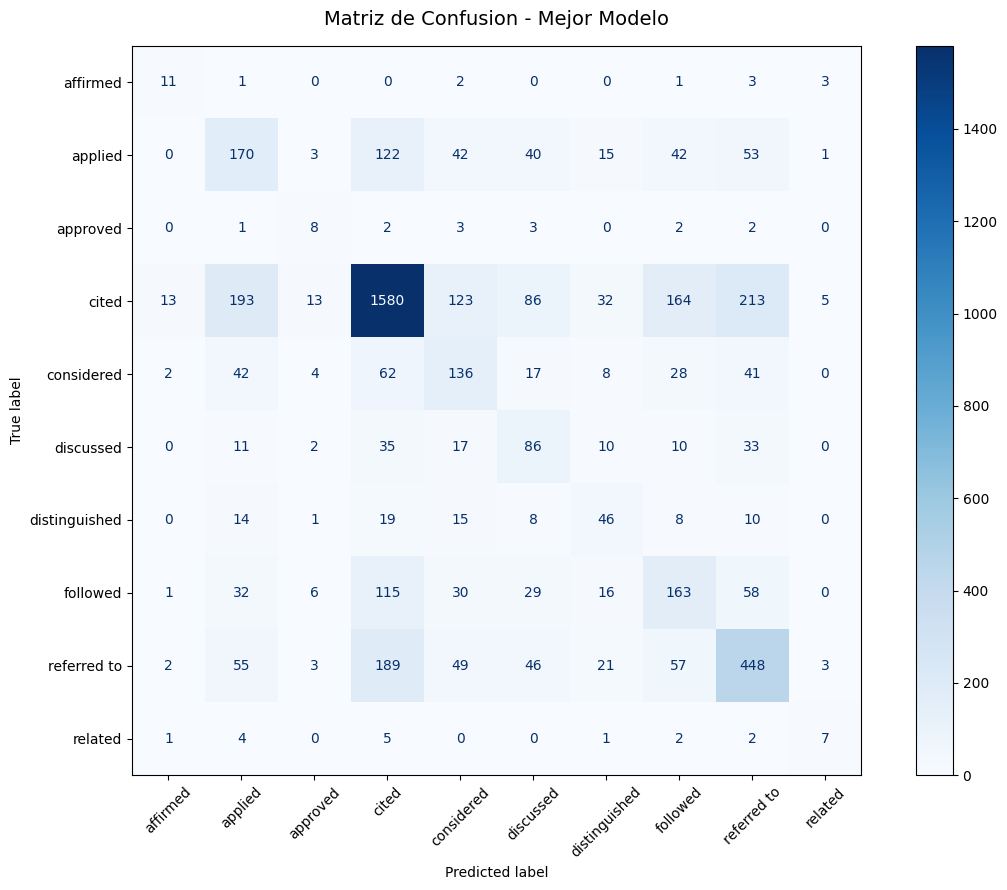

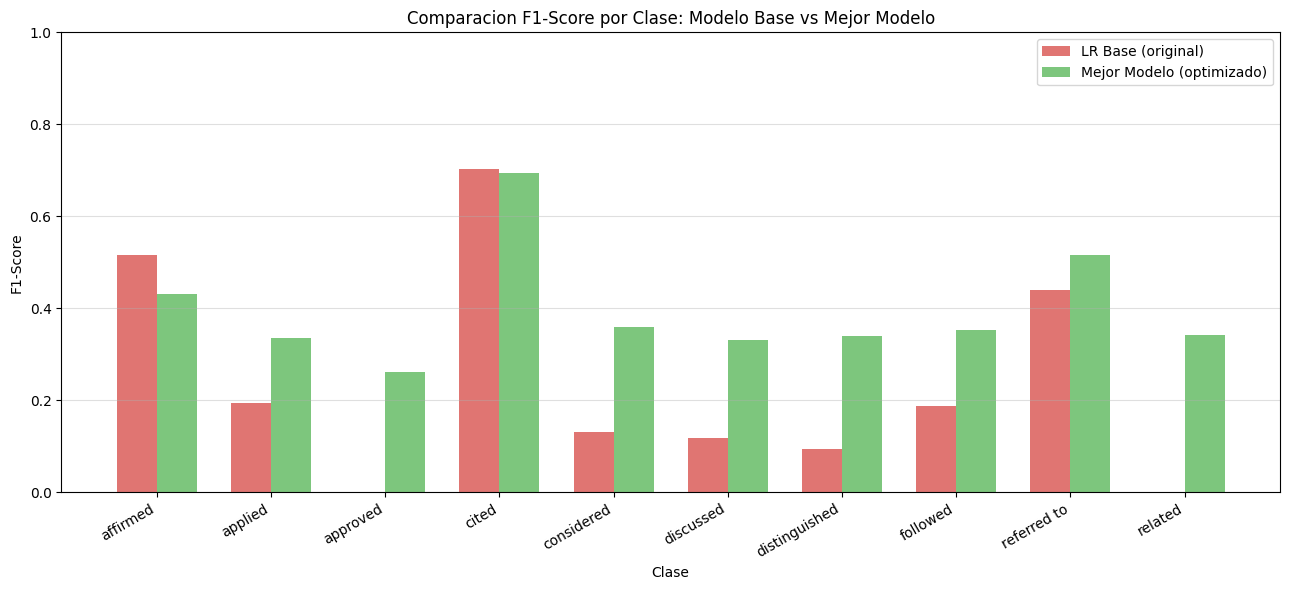

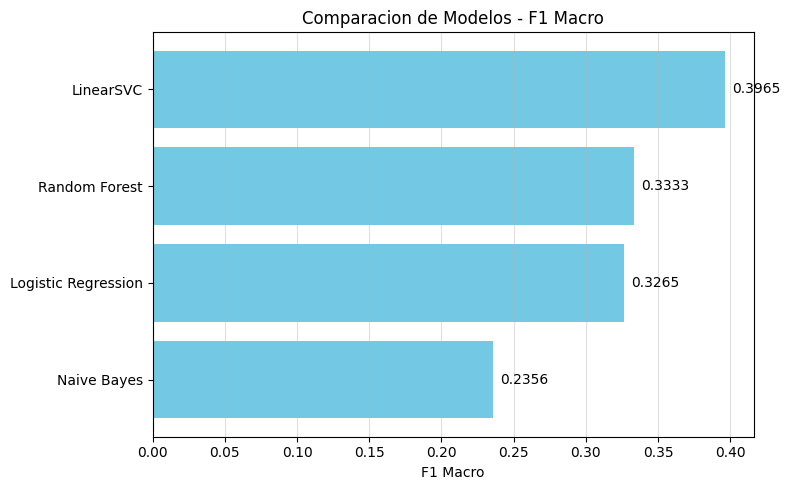

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clases = sorted(y.unique())

# --- Matriz de Confusion ---
cm = confusion_matrix(y_test, y_pred_best, labels=clases)
fig, ax = plt.subplots(figsize=(12, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(ax=ax, colorbar=True, cmap="Blues", xticks_rotation=45)
ax.set_title("Matriz de Confusion - Mejor Modelo", fontsize=14, pad=15)
plt.tight_layout()
plt.savefig("../reports/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

# --- F1 por clase: base vs mejor ---
model_base = LogisticRegression(max_iter=1000)
model_base.fit(X_train, y_train)
y_pred_base = model_base.predict(X_test)

f1_base = f1_score(y_test, y_pred_base, labels=clases, average=None, zero_division=0)
f1_best_arr = f1_score(y_test, y_pred_best, labels=clases, average=None, zero_division=0)

x = np.arange(len(clases))
width = 0.35
fig, ax = plt.subplots(figsize=(13, 6))
ax.bar(x - width/2, f1_base, width, label="LR Base (original)", color="#d9534f", alpha=0.8)
ax.bar(x + width/2, f1_best_arr, width, label="Mejor Modelo (optimizado)", color="#5cb85c", alpha=0.8)
ax.set_xlabel("Clase")
ax.set_ylabel("F1-Score")
ax.set_title("Comparacion F1-Score por Clase: Modelo Base vs Mejor Modelo")
ax.set_xticks(x)
ax.set_xticklabels(clases, rotation=30, ha="right")
ax.legend()
ax.set_ylim(0, 1.0)
ax.yaxis.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("../reports/f1_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# --- Ranking de modelos ---
fig, ax = plt.subplots(figsize=(8, 5))
df_res = df_resultados.sort_values("F1 Macro")
ax.barh(df_res.index, df_res["F1 Macro"], color="#5bc0de", alpha=0.85)
ax.set_xlabel("F1 Macro")
ax.set_title("Comparacion de Modelos - F1 Macro")
ax.xaxis.grid(True, alpha=0.4)
for i, v in enumerate(df_res["F1 Macro"]):
    ax.text(v + 0.005, i, f"{v:.4f}", va="center", fontsize=10)
plt.tight_layout()
plt.savefig("../reports/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## Guardado del Mejor Modelo

Serializamos el vectorizador TF-IDF y el modelo final con **joblib** para reutilizarlos sin necesidad de reentrenar. Esto es una practica estandar en produccion. Tambien guardamos un resumen de metricas en reports/metrics.json para registro.

In [48]:
import joblib
import json
import os
from sklearn.metrics import accuracy_score

os.makedirs("../models", exist_ok=True)

joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")
joblib.dump(mejor_modelo, "../models/best_model.pkl")
print("Modelo y vectorizador guardados en ../models/")

metricas = {
    "modelo": "LinearSVC (GridSearchCV optimizado)",
    "mejores_parametros": grid_search.best_params_,
    "accuracy": round(accuracy_score(y_test, y_pred_best), 4),
    "f1_macro": round(f1_score(y_test, y_pred_best, average="macro", zero_division=0), 4),
    "f1_weighted": round(f1_score(y_test, y_pred_best, average="weighted", zero_division=0), 4),
    "comparacion_modelos": df_resultados.round(4).to_dict(orient="index")
}

with open("../reports/metrics.json", "w") as f:
    json.dump(metricas, f, indent=2)

print("Metricas guardadas en ../reports/metrics.json")
print(f"\nResumen final:")
print(f"  Accuracy:    {metricas['accuracy']}")
print(f"  F1 Macro:    {metricas['f1_macro']}")
print(f"  F1 Weighted: {metricas['f1_weighted']}")

Modelo y vectorizador guardados en ../models/
Metricas guardadas en ../reports/metrics.json

Resumen final:
  Accuracy:    0.5351
  F1 Macro:    0.3965
  F1 Weighted: 0.5457


En esta parte analizamos la polaridad y subjetividad del texto usando TextBlob. La polaridad mide si el lenguaje es positivo o negativo (rango -1 a 1), mientras que la subjetividad indica que tan objetivo o subjetivo es el texto (0 a 1). Aunque el lenguaje legal suele ser objetivo y neutral, este analisis permite detectar variaciones semanticas entre distintas categorias de casos.

In [49]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isna(text):
        return 0.0, 0.0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df["polarity"], df["subjectivity"] = zip(*df["case_text"].apply(get_sentiment))

Aqui graficamos la distribucion de polaridad y subjetividad para observar como se comportan los textos en general. Tambien calculamos el promedio de estas metricas por categoria para comparar si ciertos tipos de decisiones legales presentan lenguaje mas negativo, mas objetivo o mas subjetivo que otros.

In [ ]:
import seaborn as sns

sns.histplot(df["polarity"], kde=True)
plt.title("Distribucion de Polaridad")
plt.show()

sns.histplot(df["subjectivity"], kde=True)
plt.title("Distribucion de Subjetividad")
plt.show()

In [ ]:
df.groupby("case_outcome")[["polarity", "subjectivity"]].mean()